In [4]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

###############################################################################
# 1) Meal / Snack Classification
###############################################################################
def classify_event(event, meals, snacks, mega_meals,
                   hourly_meals, hourly_snacks, hourly_mega_meals):
    """
    'event' is a contiguous cluster of pellet times (already offset so earliest is 0).
    day_index = int(event[0]//24), hour = int(event[0]%24).
    If day_index < 7 => increment one of the 7x24 counters.
    """
    size = len(event)
    day_index = int(event[0] // 24)
    hour = int(event[0] % 24)

    if size == 1:
        snacks.append(event)
        if 0 <= day_index < 7:
            hourly_snacks[day_index][hour] += 1
    elif 2 <= size <= 5:
        meals.append(event)
        if 0 <= day_index < 7:
            hourly_meals[day_index][hour] += 1
    else:
        mega_meals.append(event)
        if 0 <= day_index < 7:
            hourly_mega_meals[day_index][hour] += 1


def compute_metrics(meals, snacks, mega_meals, period,
                    hourly_meals, hourly_snacks, hourly_mega_meals):
    """
    Summarizes the cluster data into 15 metrics (meal_size, snack_size, etc.).
    """
    meal_size = (sum(len(m) for m in meals) / len(meals)) if meals else 0
    snack_size = (sum(len(s) for s in snacks) / len(snacks)) if snacks else 0

    number_of_meals = len(meals)
    meal_frequency = (number_of_meals / period) if period else 0

    number_of_snacks = len(snacks)
    snack_frequency = (number_of_snacks / period) if period else 0

    number_of_mega_meals = len(mega_meals)
    mega_meal_frequency = (number_of_mega_meals / period) if period else 0
    mega_meal_size = ((sum(len(m) for m in mega_meals) / number_of_mega_meals)
                      if mega_meals else 0)

    return [
        meal_size,               # 0
        snack_size,              # 1
        number_of_meals,         # 2
        meal_frequency,          # 3
        number_of_snacks,        # 4
        snack_frequency,         # 5
        mega_meal_frequency,     # 6
        mega_meal_size,          # 7
        hourly_meals,            # 8
        hourly_snacks,           # 9
        hourly_mega_meals,       #10
        meals,                   #11
        snacks,                  #12
        mega_meals,              #13
        number_of_mega_meals     #14
    ]


def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    """
    1) Sort times
    2) Offset them so that the earliest pellet is at 0.0 hours
    3) Group contiguous pellets (IPI <= meal_threshold)
    4) Classify each cluster (snack/meal/mega)
    5) Return 15 metrics
    """
    if not pellettimes:
        return [0]*15

    pellettimes = sorted(pellettimes)
    # --- SHIFT EPOCH TIMES so earliest becomes 0. ---
    offset = pellettimes[0]
    pellettimes = [t - offset for t in pellettimes]

    IPIs = np.diff(np.array(pellettimes))

    meals, snacks, mega_meals = [], [], []
    hourly_meals = [[0]*24 for _ in range(7)]
    hourly_snacks = [[0]*24 for _ in range(7)]
    hourly_mega_meals = [[0]*24 for _ in range(7)]

    current_cluster = [pellettimes[0]]
    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_cluster.append(pellettimes[i+1])
        else:
            classify_event(current_cluster, meals, snacks, mega_meals,
                           hourly_meals, hourly_snacks, hourly_mega_meals)
            current_cluster = [pellettimes[i+1]]
    # Final cluster
    classify_event(current_cluster, meals, snacks, mega_meals,
                   hourly_meals, hourly_snacks, hourly_mega_meals)

    # The total observation period is last - first
    # But after offset, the first is 0, so total period is pellettimes[-1]
    total_obs_period = pellettimes[-1] - pellettimes[0]
    if total_obs_period <= 0:
        total_obs_period = 1  # to avoid div-by-zero

    return compute_metrics(meals, snacks, mega_meals, total_obs_period,
                           hourly_meals, hourly_snacks, hourly_mega_meals)


def get_events_per_day(events, days):
    """
    Given event clusters with times already offset so earliest pellet = 0,
    day=0 => times in [0..24), day=1 => [24..48), ...
    We'll just check event[0] for the cluster start day.
    """
    events_per_day = [0]*days
    for cluster in events:
        if len(cluster) > 0:
            day_idx = int(cluster[0] // 24)
            if 0 <= day_idx < days:
                events_per_day[day_idx] += 1
    return events_per_day


def get_pellets_per_day(timestamps, days):
    """
    times are offset so earliest pellet=0.
    For day=0..days-1, we count how many pellets fall in [day*24..(day+1)*24).
    """
    pellets_per_day = [0]*days
    for t in timestamps:
        day_idx = int(t // 24)
        if 0 <= day_idx < days:
            pellets_per_day[day_idx] += 1
    return pellets_per_day

###############################################################################
# 2) Reading the CSV / Creating epoch-level lists of pellet times
###############################################################################
def get_FEDevents(filename, eventname="Pellet"):
    """
    1) Parse each row, check row[7]==eventname
    2) Convert the date/time to hours from the *first row's date* at 07:00:00
    3) Return sorted timestamps
    """
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']

    try:
        file = open(filename, 'r')
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = list(csvreader)

    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Auto-detect datetime format
    try:
        datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        date_format = formats[1]

    # The old code picks the reference point from the first row's date + "07:00:00"
    first_date_str = rows[0][0].split()[0] + " 07:00:00"
    refpoint = datetime.strptime(first_date_str, date_format)

    timestamps = []
    for row in rows:
        if row[7] == eventname:
            dt = datetime.strptime(row[0], date_format)
            pellethours = (dt - refpoint).total_seconds()/3600.0
            timestamps.append(pellethours)

    file.close()
    return sorted(timestamps)

###############################################################################
# 3) Process the METAFILE for E1..E4, each with a known # of days [9,7,7,7].
#    Exclude the first 2 days (48h) of E1 from the analysis.
###############################################################################
def process_metafile(metafile):
    rows, _ = tp.metafilereader(metafile, sheetname="METAFILE")
    mice = {}

    for row in rows:
        fedfile = row[0]    # filename
        mouse_id = row[1]   # e.g. 'MouseA'
        sex = row[4]
        order_ = row[5]
        epoch = row[6]      # e.g. 'E1','E2','E3','E4'

        if mouse_id not in mice:
            mice[mouse_id] = {"sex": sex, "order": order_}

        epoch_key = f"epoch_{epoch}"
        # Read raw pellet times
        fname = f"../data/{fedfile}"
        pellettimes = get_FEDevents(fname, "Pellet")
        mice[mouse_id][epoch_key] = pellettimes

    # For each mouse, for each epoch -> compute metrics
    for mouse, info in mice.items():

        # E1=9 days total, but we drop the first 2 days => effectively 7 days remain
        for epoch, days in zip(["E1","E2","E3","E4"], [9,7,7,7]):
            epoch_key = f"epoch_{epoch}"
            raw_times = info.get(epoch_key, [])
            times = raw_times[:]  # make a copy so we can log differences

            if epoch == "E1":
                # Count how many are < 48 hours
                removed_count = sum(t < 48 for t in times)
                # Filter out all events that occurred before 48h
                times = [t for t in times if t >= 48]
                # Subtract 48 so that new day 0 is old hour 48
                times = [t - 48 for t in times]

                # Log how many pellets we removed
                print(f"Mouse: {mouse}, E1: removed {removed_count} pellets (before 48h).",
                      f"Remaining pellets: {len(times)}.")

                # Now we only analyze the next 7 days
                day_count = 7
            else:
                day_count = days

            # Compute meal/snack metrics
            metrics = get_meal_and_snack_metrics(times)
            (meal_size, snack_size,
             number_of_meals, meal_frequency,
             number_of_snacks, snack_frequency,
             mega_meal_frequency, mega_meal_size,
             hourly_meals, hourly_snacks, hourly_mega_meals,
             raw_meals, raw_snacks, raw_mega_meals,
             number_of_mega_meals) = metrics

            # Store the epoch-level metrics
            info[f"{epoch_key}_meal_size"] = meal_size
            info[f"{epoch_key}_snack_size"] = snack_size
            info[f"{epoch_key}_number_of_meals"] = number_of_meals
            info[f"{epoch_key}_meal_frequency"] = meal_frequency
            info[f"{epoch_key}_number_of_snacks"] = number_of_snacks
            info[f"{epoch_key}_snack_frequency"] = snack_frequency
            info[f"{epoch_key}_mega_meal_frequency"] = mega_meal_frequency
            info[f"{epoch_key}_mega_meal_size"] = mega_meal_size
            info[f"{epoch_key}_number_of_mega_meals"] = number_of_mega_meals

            # For day-by-day tallies, we offset "times" again:
            if times:
                tmin = min(times)
                offset_times = [t - tmin for t in times]
            else:
                offset_times = []

            # The get_events_per_day() / get_pellets_per_day() each expect
            # "already offset" times/clusters in range [0..(day_count*24)]
            info[f"{epoch_key}_pellets_per_day"] = get_pellets_per_day(offset_times, day_count)
            info[f"{epoch_key}_meals_per_day"]   = get_events_per_day(raw_meals, day_count)
            info[f"{epoch_key}_snacks_per_day"]  = get_events_per_day(raw_snacks, day_count)
            info[f"{epoch_key}_mega_meals_per_day"] = get_events_per_day(raw_mega_meals, day_count)

    return mice


if __name__ == "__main__":
    metafile_path = "../FEDXC_METAFILE.csv"
    mice_data = process_metafile(metafile_path)

    # Save everything to CSV
    output_file = "epoch_analysis_results_FIXED_UPDATE.csv"
    fieldnames = (
        ["mouse_id","sex","order"] +
        [f"epoch_{ep}_{met}"
         for ep in ["E1","E2","E3","E4"]
         for met in ["meal_size","snack_size","number_of_meals","meal_frequency",
                     "number_of_snacks","snack_frequency","mega_meal_frequency",
                     "mega_meal_size","number_of_mega_meals",
                     "pellets_per_day","meals_per_day","snacks_per_day","mega_meals_per_day"]]
    )

    with open(output_file,"w",newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for mouse_id, info in mice_data.items():
            row = {
                "mouse_id": mouse_id,
                "sex": info["sex"],
                "order": info["order"]
            }
            for ep in ["E1","E2","E3","E4"]:
                ep_key = f"epoch_{ep}"
                for met in ["meal_size","snack_size","number_of_meals","meal_frequency",
                            "number_of_snacks","snack_frequency","mega_meal_frequency",
                            "mega_meal_size","number_of_mega_meals",
                            "pellets_per_day","meals_per_day","snacks_per_day","mega_meals_per_day"]:
                    row[f"{ep_key}_{met}"] = info.get(f"{ep_key}_{met}", 0)
            writer.writerow(row)

    print(f"Saved new file: {output_file}")


Mouse: FEDXC01, E1: removed 371 pellets (before 48h). Remaining pellets: 1108.
Mouse: FEDXC02, E1: removed 488 pellets (before 48h). Remaining pellets: 1311.
Mouse: FEDXC03, E1: removed 381 pellets (before 48h). Remaining pellets: 1185.
Mouse: FEDXC04, E1: removed 473 pellets (before 48h). Remaining pellets: 1230.
Mouse: FEDXC05, E1: removed 458 pellets (before 48h). Remaining pellets: 1263.
Mouse: FEDXC06, E1: removed 433 pellets (before 48h). Remaining pellets: 1206.
Mouse: FEDXC07, E1: removed 230 pellets (before 48h). Remaining pellets: 1279.
Mouse: FEDXC08, E1: removed 413 pellets (before 48h). Remaining pellets: 1304.
Mouse: FEDXC09, E1: removed 444 pellets (before 48h). Remaining pellets: 1269.
Mouse: FEDXC10, E1: removed 470 pellets (before 48h). Remaining pellets: 1358.
Mouse: FEDXC11, E1: removed 468 pellets (before 48h). Remaining pellets: 1315.
Mouse: FEDXC12, E1: removed 442 pellets (before 48h). Remaining pellets: 1403.
Saved new file: epoch_analysis_results_FIXED_UPDATE.

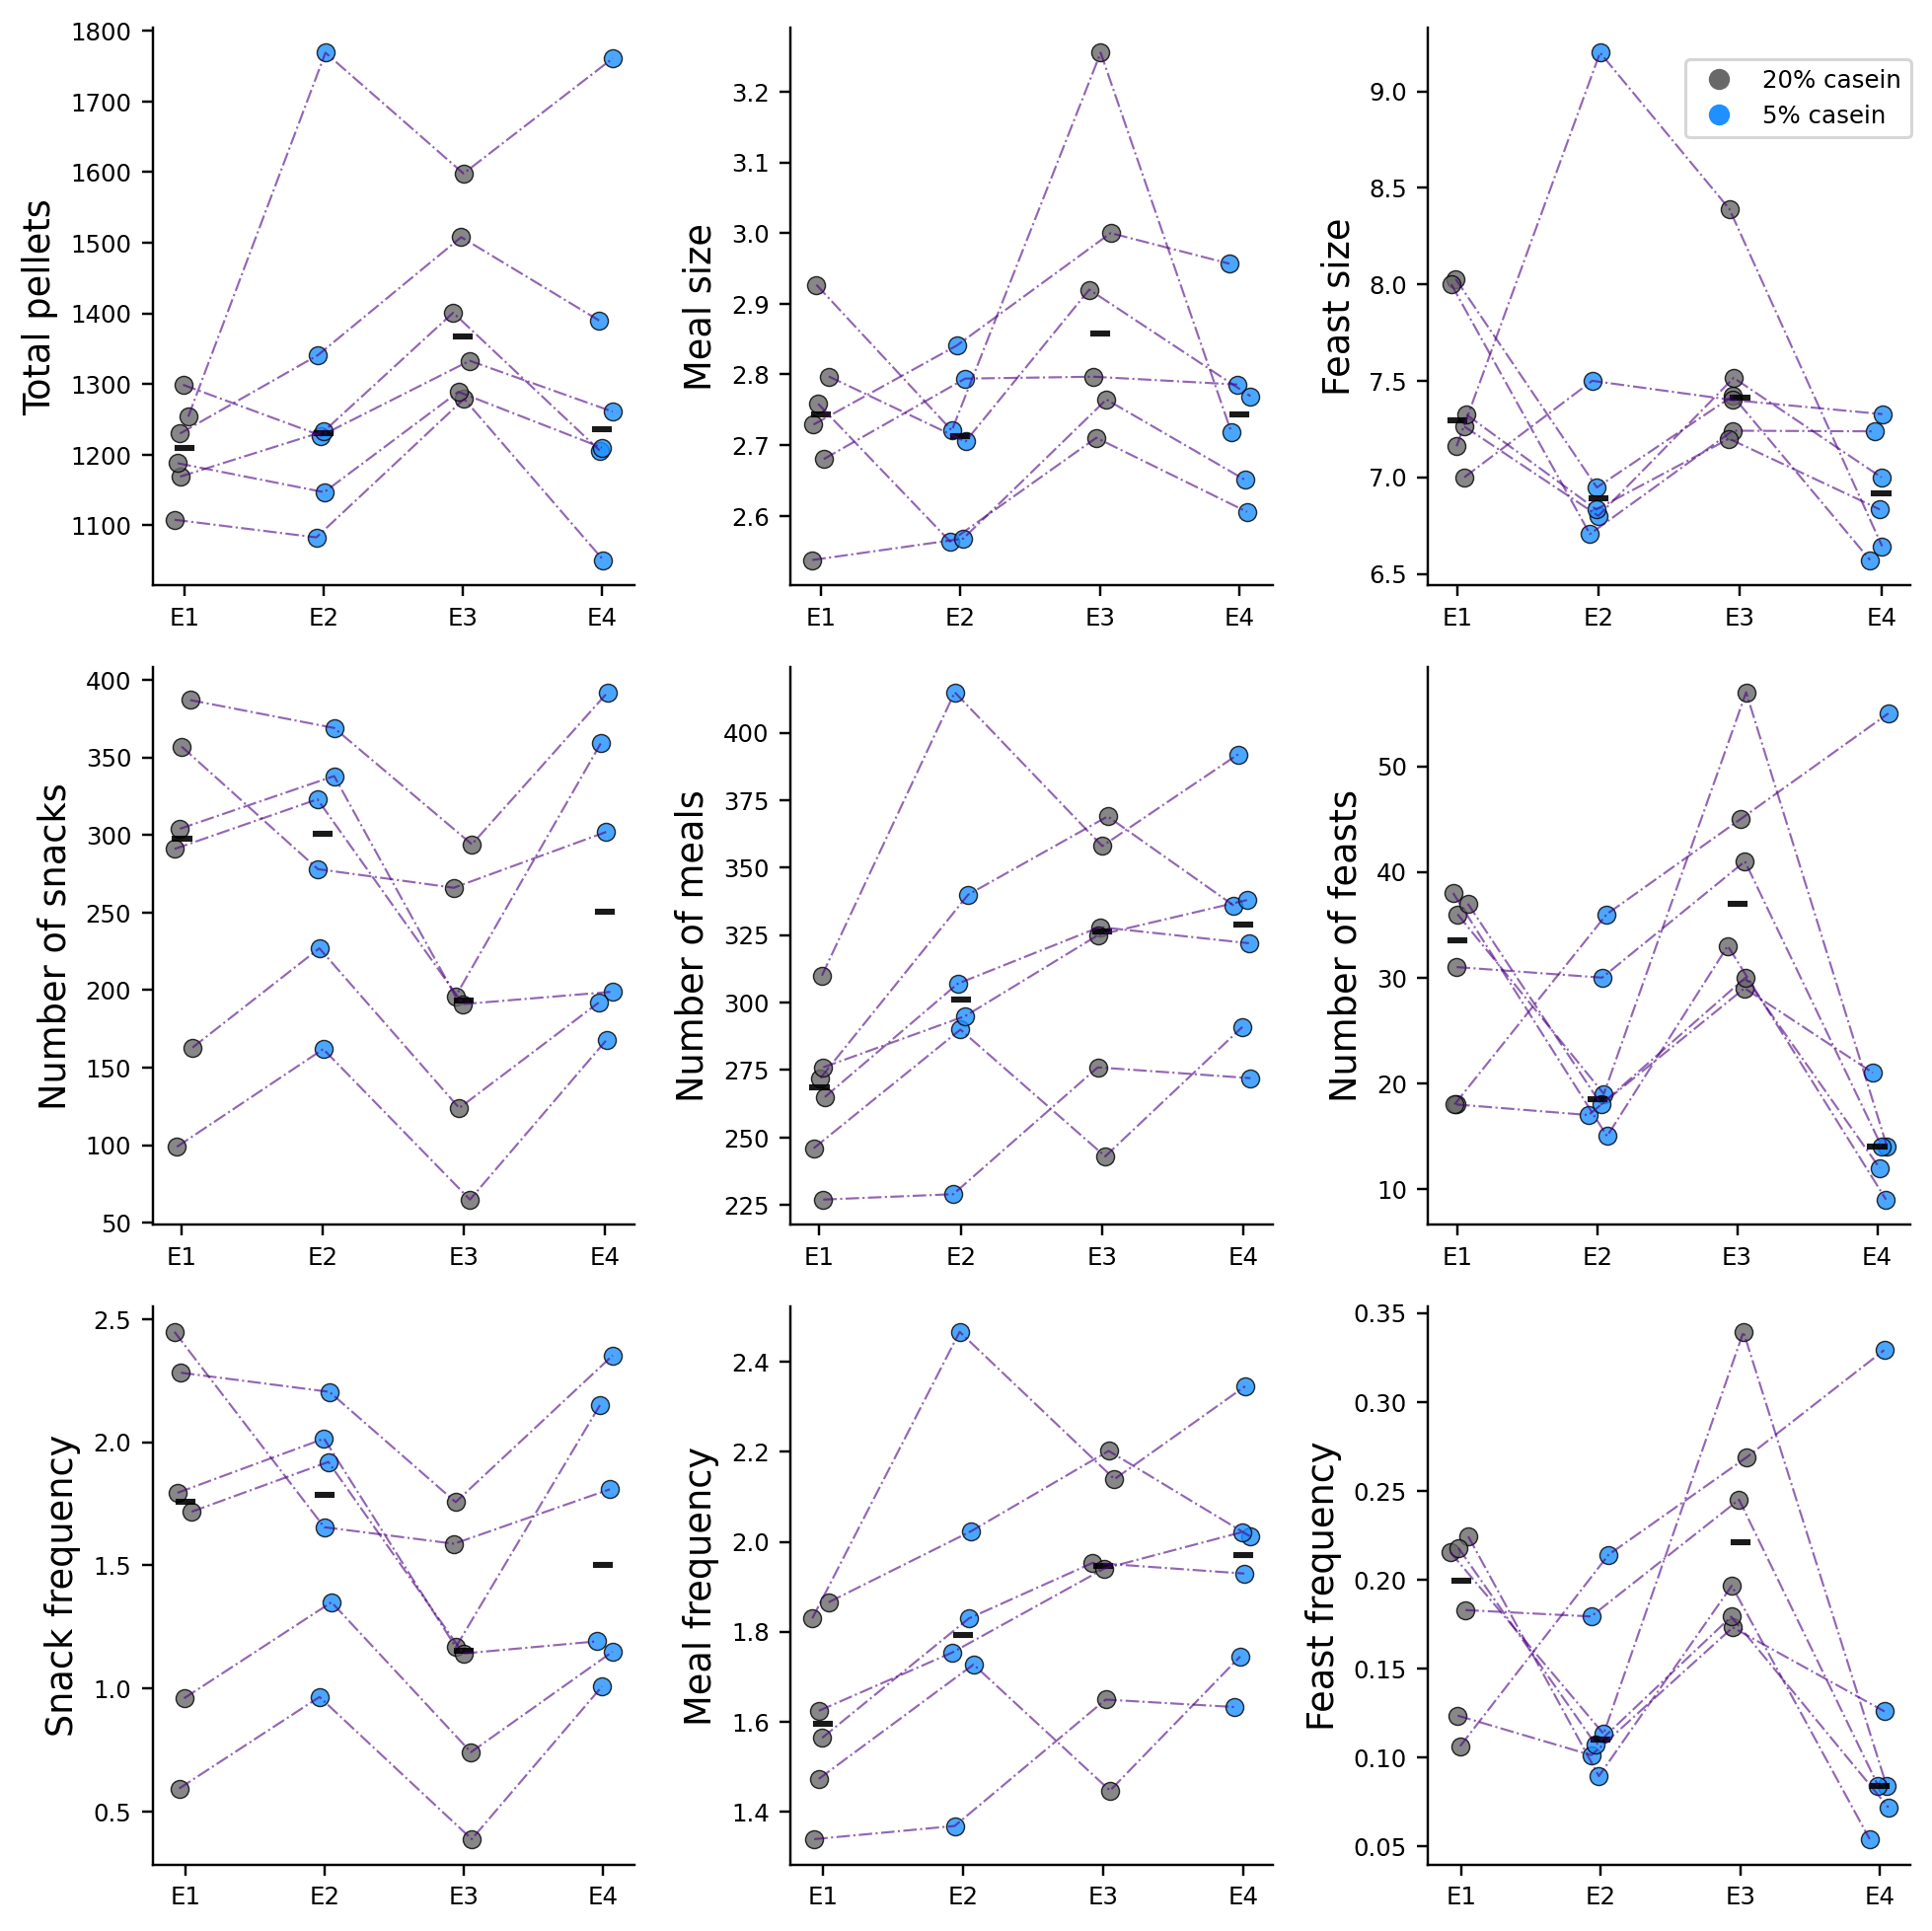

In [8]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from matplotlib.lines import Line2D

# ----------------------------------------------------------------
# 1. Load CSV and convert columns to lists
# ----------------------------------------------------------------
epoch_results_path = "epoch_analysis_results_FIXED(SCATTER).csv"
epoch_results_df = pd.read_csv(epoch_results_path)

def convert_to_list(value):
    try:
        if isinstance(value, str):
            return ast.literal_eval(value)
        elif isinstance(value, (int, float)):
            return [value]  # wrap single numeric value in a list
        else:
            return value
    except (SyntaxError, ValueError):
        return []

# Apply conversion to relevant columns
for epoch in ["E1", "E2", "E3", "E4"]:
    for metric in [
        "number_of_snacks", "number_of_meals", "number_of_mega_meals",
        "meal_size", "mega_meal_size", "snack_frequency", "meal_frequency",
        "mega_meal_frequency", "pellets_per_day"
    ]:
        col = f"epoch_{epoch}_{metric}"
        if col in epoch_results_df.columns:
            epoch_results_df[col] = epoch_results_df[col].apply(convert_to_list)

# ----------------------------------------------------------------
# 2. Sum metrics per epoch (excluding first 2 days in E1)
# ----------------------------------------------------------------
metrics_to_plot = [
    "number_of_snacks", "number_of_meals", "number_of_mega_meals",
    "meal_size", "mega_meal_size", "snack_frequency", "meal_frequency",
    "mega_meal_frequency", "pellets_per_day"
]

# Prepare dict to store sums
total_metrics_per_epoch = {
    metric: {
        epoch: {"Order 1": [], "Order 2": []}
        for epoch in ["E1", "E2", "E3", "E4"]
    } for metric in metrics_to_plot
}

# Populate sums for each mouse
for _, row in epoch_results_df.iterrows():
    order_str = f"Order {row['order']}"
    for epoch in ["E1", "E2", "E3", "E4"]:
        for metric in metrics_to_plot:
            metric_data = row[f"epoch_{epoch}_{metric}"]
            if not isinstance(metric_data, list):
                metric_data = [metric_data]
            # Exclude first 2 days for E1
            # if epoch == "E1" and len(metric_data) > 2:
            #     metric_data = metric_data[2:]
            total_value = sum(metric_data)
            total_metrics_per_epoch[metric][epoch][order_str].append(total_value)

# ----------------------------------------------------------------
# 3. Metric label mapping (capitalize first letter, rest lower)
#    with 'mega meals' -> 'feasts'
# ----------------------------------------------------------------
rename_labels = {
    "pellets_per_day":        "Total pellets",
    "meal_size":              "Meal size",
    "mega_meal_size":         "Feast size",
    "number_of_snacks":       "Number of snacks",
    "number_of_meals":        "Number of meals",
    "number_of_mega_meals":   "Number of feasts",
    "snack_frequency":        "Snack frequency",
    "meal_frequency":         "Meal frequency",
    "mega_meal_frequency":    "Feast frequency"
}

def get_ylabel(metric):
    """Return a custom label for the metric."""
    return rename_labels.get(metric, metric)

# ----------------------------------------------------------------
# 4. Plotting helper: a single metric for Order 2
# ----------------------------------------------------------------
def plot_metric_for_order2(ax, metric, total_dict):
    """Scatter + median line + connecting lines for Order 2 (E1–E4)."""
    epochs = ["E1", "E2", "E3", "E4"]
    x_positions = {"E1": 0, "E2": 1, "E3": 2, "E4": 3}
    epoch_colors = {"E1": "dimgray", "E2": "dodgerblue", 
                    "E3": "dimgray", "E4": "dodgerblue"}
    jitter_strength = 0.08
    
    # Extract data
    order2_data_by_epoch = {ep: total_dict[metric][ep]["Order 2"] for ep in epochs}
    num_mice = len(order2_data_by_epoch["E1"])
    
    # Plot each epoch with jitter + median
    jittered_x_positions = {}
    for ep in epochs:
        x_pos = x_positions[ep]
        data = order2_data_by_epoch[ep]
        jittered_x = [x_pos + np.random.uniform(-jitter_strength, jitter_strength) 
                      for _ in data]
        jittered_x_positions[ep] = jittered_x
        
        sns.scatterplot(
            x=jittered_x, y=data, ax=ax,
            color=epoch_colors[ep], edgecolor="black",
            marker='o', s=35, alpha=0.8
        )
        
        # Median line
        median_val = np.median(data) if len(data) > 0 else 0
        ax.plot([x_pos - 0.05, x_pos + 0.05], [median_val, median_val],
                color='black', linewidth=2, alpha=0.9)
    
    # Connect each mouse's data across epochs
    for i in range(num_mice):
        x_line = [jittered_x_positions[ep][i] for ep in epochs]
        y_line = [order2_data_by_epoch[ep][i] for ep in epochs]
        ax.plot(x_line, y_line, color='indigo', linestyle='-.',
                linewidth=0.7, alpha=0.6)
    
    # Axis formatting
    ax.set_xticks([x_positions[ep] for ep in epochs])
    ax.set_xticklabels(epochs, fontsize=8)  # smaller tick labels
    ax.tick_params(axis='both', labelsize=8)
    ax.set_ylabel(get_ylabel(metric), fontsize=12)
    sns.despine(ax=ax)

# ----------------------------------------------------------------
# 5. Single figure, 3 rows × 3 columns
#    Row1: [pellets_per_day, meal_size, mega_meal_size]
#    Row2: [number_of_snacks, number_of_meals, number_of_mega_meals]
#    Row3: [snack_frequency, meal_frequency, mega_meal_frequency]
# ----------------------------------------------------------------
all_metrics = [
    ["pellets_per_day", "meal_size", "mega_meal_size"],
    ["number_of_snacks", "number_of_meals", "number_of_mega_meals"],
    ["snack_frequency",  "meal_frequency",  "mega_meal_frequency"]
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9), dpi=220)

# If you’d like a uniform y-scale per row, consider sharey='row',
# but each metric might differ in scale, so we use sharey=False.

for r in range(3):
    for c in range(3):
        metric = all_metrics[r][c]
        ax = axes[r][c]
        plot_metric_for_order2(ax, metric, total_metrics_per_epoch)

# Create a single legend in the top-right corner of the figure
custom_legend = [
    Line2D([0], [0], marker='o', linestyle='', 
           color='dimgray', markerfacecolor='dimgray',
           label='20% casein', markersize=6),
    Line2D([0], [0], marker='o', linestyle='',
           color='dodgerblue', markerfacecolor='dodgerblue',
           label='5% casein', markersize=6)
]

# Position the legend at the top-right outside the subplot grid
fig.legend(
    handles=custom_legend,
    loc="upper right", bbox_to_anchor=(0.99, 0.97),
    frameon=True, fontsize=8
)

plt.tight_layout()
plt.show()

# Save if desired:
# fig.savefig("AllMetrics_OneFigure.png", bbox_inches='tight', dpi=150)
